In [1]:
import lightgbm as lgb
import shap
from Reader import Reader
import os
import json
import seaborn as sns

import numpy as np
from matplotlib import pyplot as plt

Welcome to JupyROOT 6.18/04


In [2]:
shap.initjs()

In [3]:
channel = 'mt'
era = '2018'
samples = f'conf/global_config_{channel}_{era}.json'
use = 'lgb'

# train = False
# short = True
# datacard = False
# add_nominal = False

In [4]:
read = Reader(channel = channel, config_file = samples, folds=2, era = era)

In [5]:
target_names = read.config["target_names"]
variables = read.config["variables"]

models_folder = era + "/models"
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

modelname = f'{models_folder}/{channel}.{use}'
scaler = None

In [6]:
trainSet = read.getSamplesForTraining()




------> Loading: TTJ from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck

size of TTJ is 9109



------> Loading: TTL from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck

size of TTL is 44479



------> Loading: TTT from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck

size of TTT is 6003



------> Loading: VVJ from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck

size of VVJ is 6884



------> Loading: VVL from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck

size of VVL is 6036



------> Loading: VVT from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck

size of VVT is 1939



------> Loading: W from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck

size of W is 15615



------> Loading: ZJ from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck

size of ZJ is 8335



------> Loading: ZL from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck

size of ZL is 6318



------> Loading: ZTT from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck

size of

In [8]:
train_data = trainSet[1][:150000]
test_data = trainSet[0][:150000]

In [9]:
dtrain = lgb.Dataset(  train_data[variables].values,
                       label=train_data['target'].values,
                       weight=train_data['train_weight'].values )

dtest = lgb.Dataset( test_data[variables].values,
                     label=test_data['target'].values,
                     weight=test_data['train_weight'].values,
                     reference=dtrain)

In [10]:
parameter_file = "conf/parameters_lgb.json"
with open(parameter_file,"r") as FSO:
    params = json.load(FSO)['multiclass']
params["num_class"] = 3

model = lgb.train(params = params,
                train_set=dtrain,
                valid_sets=[dtest]
                )

Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's multi_logloss: 1.05732
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 1.02303
[3]	valid_0's multi_logloss: 0.993377
[4]	valid_0's multi_logloss: 0.967459
[5]	valid_0's multi_logloss: 0.944643
[6]	valid_0's multi_logloss: 0.924613
[7]	valid_0's multi_logloss: 0.907072
[8]	valid_0's multi_logloss: 0.891806
[9]	valid_0's multi_logloss: 0.878114
[10]	valid_0's multi_logloss: 0.865339
[11]	valid_0's multi_logloss: 0.854394
[12]	valid_0's multi_logloss: 0.844258
[13]	valid_0's multi_logloss: 0.835581
[14]	valid_0's multi_logloss: 0.827907
[15]	valid_0's multi_logloss: 0.820849
[16]	valid_0's multi_logloss: 0.814711
[17]	valid_0's multi_logloss: 0.809116
[18]	valid_0's multi_logloss: 0.804029
[19]	valid_0's multi_logloss: 0.799788
[20]	valid_0's multi_logloss: 0.79537
[21]	valid_0's multi_logloss: 0.791734
[22]	valid_0's multi_logloss: 0.788273
[23]	valid_0's multi_logloss: 0.785125
[24]	valid_0's multi_logloss: 0.782562
[25]	valid_0's 

In [15]:
np.unique(train_data.target, return_counts=True)

(array([0, 1, 2]), array([124322,  17703,   7975]))

In [15]:
np.unique(trainSet[0].target, return_counts=True)

(array([0, 1, 2]), array([124322,  17703,   7975]))

### **Native LightGBM importance**

In [11]:
for i, column in enumerate(train_data[variables].columns):
    print(f'{i}: {column}')

0: pt_1
1: pt_2
2: jpt_1
3: jpt_2
4: dijetpt
5: jdeta
6: njets
7: m_fast
8: mjj
9: m_vis
10: puppimt_1
11: pt_tt
12: puppimet


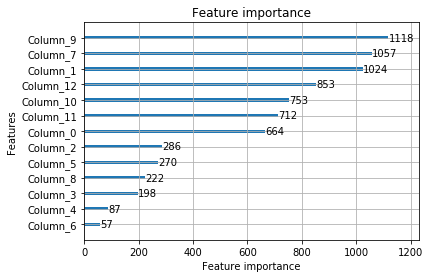

In [12]:
lgb.plot_importance(model, importance_type='split')
plt.savefig(f'./SHAP_plots/train1_150k_{era}_split.png')

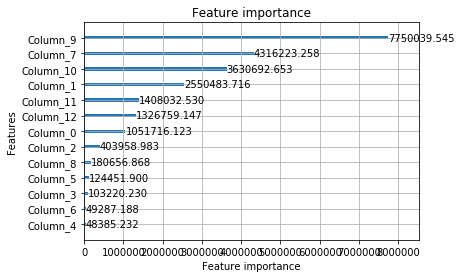

In [13]:
lgb.plot_importance(model, importance_type='gain')
plt.savefig(f'./SHAP_plots/train1_150k_{era}_gain.png')

### **SHAP**

In [23]:
1/(1+np.exp(-np.array(expected_values)))

array([0.41019065, 0.15604258, 0.1294883 ])

In [21]:
np.array(expected_values).mean()

-1.3188803499879855

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_data[variables])
expected_values = explainer.expected_value

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


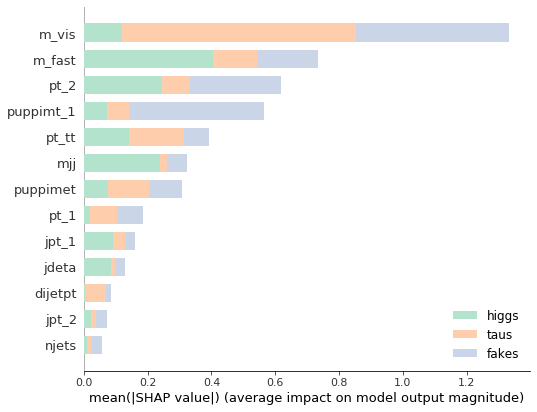

In [15]:
plt.figure()
shap.summary_plot(shap_values, test_data[variables], color=plt.get_cmap("Pastel2"), class_inds=(0,1,2), class_names=['higgs', 'taus', 'fakes'], show=False)
plt.savefig(f'./SHAP_plots/train1_150k_{era}.png')
plt.savefig(f'./SHAP_plots/train1_150k_{era}.pdf')
# plt.close()

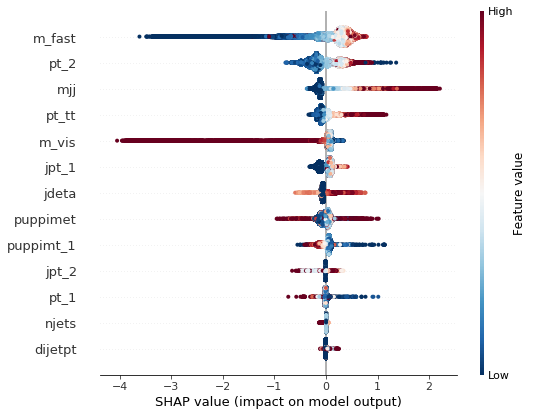

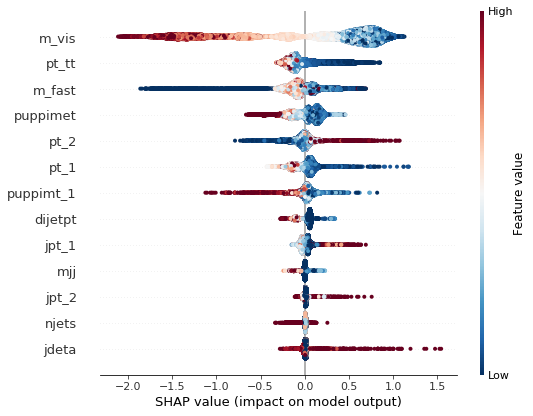

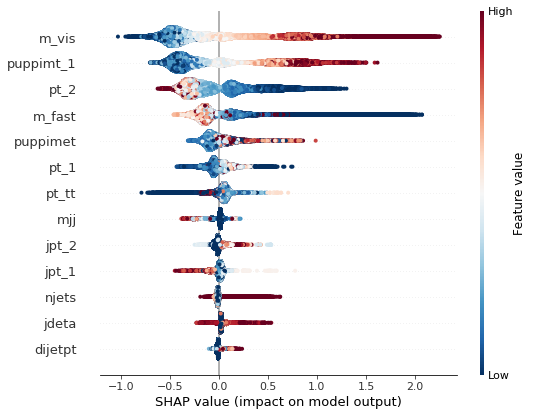

In [16]:
for cat_id in [0, 1, 2]:
    my_cmap = plt.get_cmap('RdBu_r')

    # Plot the summary without showing it
    plt.figure()

    shap.summary_plot(shap_values[cat_id], test_data[variables], show=False)

    # Change the colormap of the artists
    for fc in plt.gcf().get_children():
        for fcc in fc.get_children():
            if hasattr(fcc, "set_cmap"):
                fcc.set_cmap(my_cmap)
    plt.savefig(f'./SHAP_plots/train1_150k_{era}_{cat_id}.png')
    plt.savefig(f'./SHAP_plots/train1_150k_{era}_{cat_id}.pdf')

### **Dependance & Interactions**

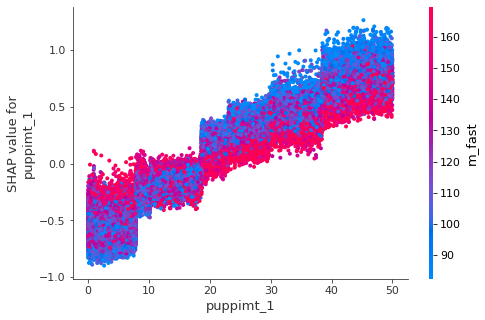

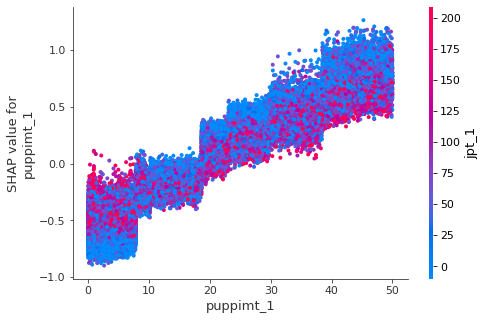

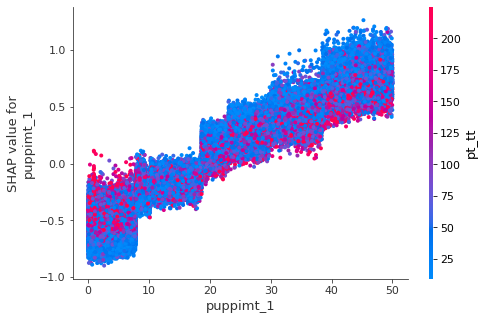

In [73]:
inds = shap.approximate_interactions('puppimt_1', shap_values[2], test_data[variables])

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot('puppimt_1', shap_values[2], test_data[variables], interaction_index=inds[i])


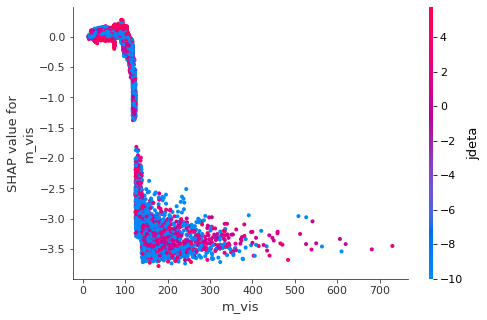

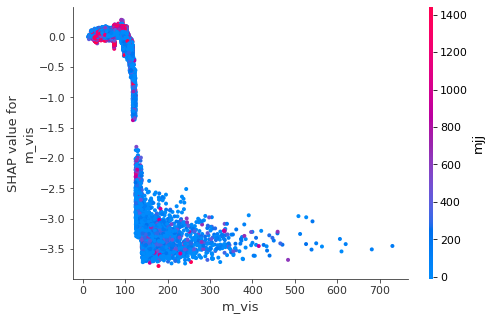

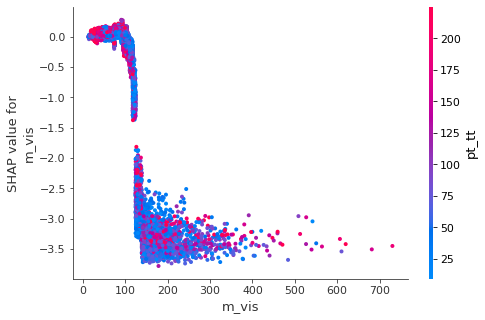

In [83]:
var = 'm_vis'
cat_id = 0

inds = shap.approximate_interactions(var, shap_values[cat_id], test_data[variables])

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot(var, shap_values[cat_id], test_data[variables], interaction_index=inds[i])


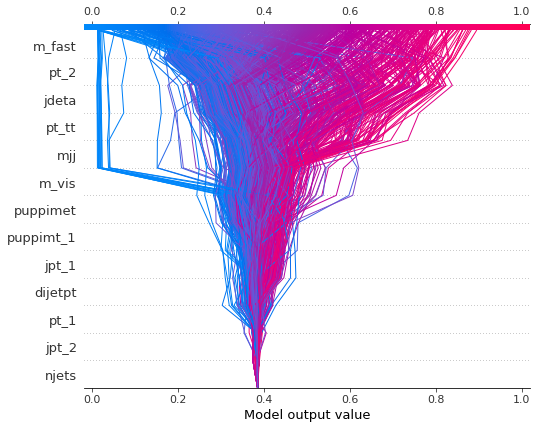

In [93]:
shap.decision_plot(expected_values[0], shap_values[0][:1000], test_data[variables][:1000], link='logit')

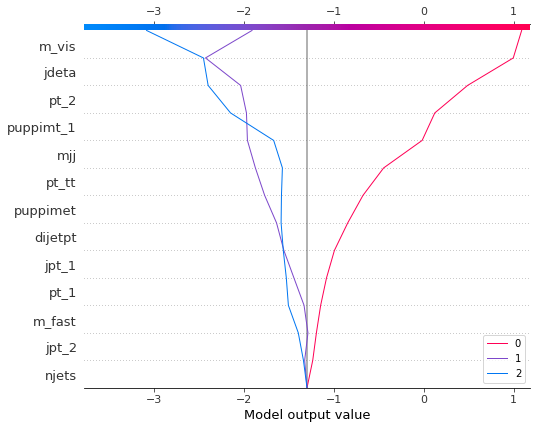

In [103]:
row_index = 289
shap.multioutput_decision_plot(expected_values, shap_values,
                               row_index=row_index,
                               feature_names=variables, 
                               legend_labels=['0', '1', '2'],
                               legend_location='lower right')    